In [120]:
import math
from numpy import linalg as LA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [132]:
def visualize_4d(frame, hot=True):
  fig = plt.figure(figsize=(12, 12))
  ax = fig.add_subplot(111, projection='3d')
  x = np.array(frame.iloc[:,0])
  if len(frame.columns) > 1:
    y = np.array(frame.iloc[:,1])
  if len(frame.columns) > 2:
    z = np.array(frame.iloc[:,2])
  if len(frame.columns) == 1:
    img = ax.scatter(x, x, s=2)
  if len(frame.columns) == 2:
    img = ax.scatter(x, y, s=2)
  elif len(frame.columns) == 3:
    img = ax.scatter(x, y, z, s=2)
  else:
    c = np.array(frame.iloc[:,3])
    if hot:
      img = ax.scatter(x, y, z, c=c, cmap=plt.hot(), s=2)
    else:
      img = ax.scatter(x, y, z, c=c, cmap='viridis', s=2)
  plt.show()
def show_distance_graph(X):
  neigh = NearestNeighbors(n_neighbors=2)
  nbrs = neigh.fit(X)
  distances, indices = nbrs.kneighbors(X)
  # Plotting K-distance Graph
  distances = np.sort(distances, axis=0)
  distances = distances[:,1]
  print(distances[-1000:])
  plt.figure(figsize=(10,5))
  plt.plot(distances[:-1000])
  plt.title('K-distance Graph',fontsize=20)
  plt.xlabel('Data Points sorted by distance',fontsize=14)
  plt.ylabel('Epsilon',fontsize=14)
  plt.show()
def get_pca_centered(X, center):
  for i in range(len(X)):
    X[i] -= center
  M = np.matrix(X).transpose()
  #Calculating the local covariance matrix for each point
  C = M * M.transpose()
  return LA.eig(C)

In [3]:
# Input
file = open('./R32.txt','r')
d,n,m,k,p = list(file.readline().split())
d, n, p = map(int, [d, n, p])
k_list = list(map(int,file.readline().split()))
ar=[]
for i in range(0,n):
  ar.append(list(map(float,file.readline().split())))
df= pd.DataFrame(ar)
df.describe()
%matplotlib notebook
visualize_4d(df)

<IPython.core.display.Javascript object>

In [199]:
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors


def get_pca(x):
  pca = PCA()
  pca.fit_transform(x)
  return pca.explained_variance_ratio_, pca.components_

def get_dimension(space, x, threshold=0.001):
  dim = 0
  for e in get_pca_centered(space, x)[0]:
    if e >= threshold:
      dim += 1
  return dim

class DSCAN:

  def __init__(self, n_neighbor=100, n_ignore=10, n_local=50, max_dis=10):
    self.distances = None
    self.neighbors = None
    self.real_neigh = None
    self.local_neigh = None
    self.points = None
    self.n_ignore = n_ignore
    self.max_dis = max_dis
    self.n_local = n_local
    self.dims = None
    self.pca_components = None
    self.var_components = None
    self.components_ = None
    self.n_neighbor = n_neighbor

  def get_local(self, x):
    res = [x]
    for ind in self.local_neigh[x]:
      p = self.points[ind]
      if np.linalg.norm(self.points[x] - p) <= self.max_dis:
        res.append(ind)
    return np.asarray(res, dtype=np.int32)

  def get_local_points(self, x):
    res = []
    for u in self.get_local(x):
      res.append(self.points[u])
    return np.asarray(res)

  def is_connected(self, x, y):
    if self.dims[x] == self.dims[y]:
      return True
    Xv, Xc = self.var_components[x] ,self.pca_components[x]
    Yv, Yc = self.var_components[y] ,self.pca_components[y]
    for i in range(len(Xv)):
      if Xv[i] < 1 / d:
        continue
      res = 2 - max(np.linalg.norm(Xc[i] - Yc[i]), np.linalg.norm(Xc[i] + Yc[i]))
      if np.arccos(res) <= np.pi / 180:
        return False
    return True

  def fit(self, X):
    nbrs = NearestNeighbors(n_neighbors=self.n_neighbor).fit(X)
    self.distances, self.neighbors = nbrs.kneighbors(X)
    self.real_neigh = [self.neighbors[i][self.n_ignore:] for i in range(len(X))]
    self.local_neigh = [self.neighbors[i][:self.n_local] for i in range(len(X))]
    self.points = X.to_numpy()
    self.components_ = np.full((len(X)), -1)
    self.pca_components = []
    self.var_components = []
    self.dims = []
    for v in range(len(X)):
      vcomp, pcomp  = get_pca_centered(self.get_local_points(v), self.points[v])
      self.pca_components.append(pcomp)
      self.var_components.append(vcomp)
      self.dims.append(get_dimension(self.get_local_points(v), self.points[v]))
    return self

  def predict(self):
    cnt = 0
    ind = 0
    c = -1
    while True:
      while ind < len(self.points):
        if self.components_[ind] == -1:
          break
        ind += 1
      if ind == len(self.points):
        break
      stack = [ind]
      c += 1
      while len(stack) > 0:
        cnt += 1
        if cnt % 1000 == 0:
          print(f'{cnt} - {len(stack)}')
        v = stack.pop()
        self.components_[v] = c
        for u in self.real_neigh[v]:
          if self.components_[u] == -1 and self.is_connected(v, u):
            stack.append(u)
            self.components_[u] = c
    return self.components_


In [ ]:
from sklearn.preprocessing import StandardScaler
normdf = pd.DataFrame(StandardScaler(with_mean=False).fit_transform(df), columns=[i for i in range(d)])
show_distance_graph(normdf)

In [200]:
from sklearn.cluster import DBSCAN
res = df.copy()
self = DSCAN(n_neighbor=50, n_ignore=10, n_local=10, max_dis=7).fit(df)
res['manifold'] = self.predict()
visualize_4d(res[[0,1,2,'manifold']], hot=False)
res['manifold'].describe()

1000 - 1096
2000 - 602
3000 - 746
4000 - 1514
5000 - 551
6000 - 577
7000 - 644
8000 - 402
9000 - 2155
10000 - 1202
11000 - 241
12000 - 1907
13000 - 959
14000 - 198
15000 - 1678
16000 - 704
17000 - 52
18000 - 329
19000 - 495
20000 - 2609
21000 - 3091
22000 - 2126
23000 - 3273
24000 - 3428
25000 - 2468
26000 - 1563
27000 - 715
28000 - 1900
29000 - 942
30000 - 452
31000 - 2183
32000 - 1233
33000 - 278
34000 - 1960
35000 - 988
36000 - 30
37000 - 1492
38000 - 533
39000 - 387
40000 - 1448
41000 - 474
42000 - 2003
43000 - 1247
44000 - 321


<IPython.core.display.Javascript object>

count    44324.000000
mean        14.204472
std          9.178781
min          0.000000
25%          4.000000
50%         15.000000
75%         20.000000
max         28.000000
Name: manifold, dtype: float64

1


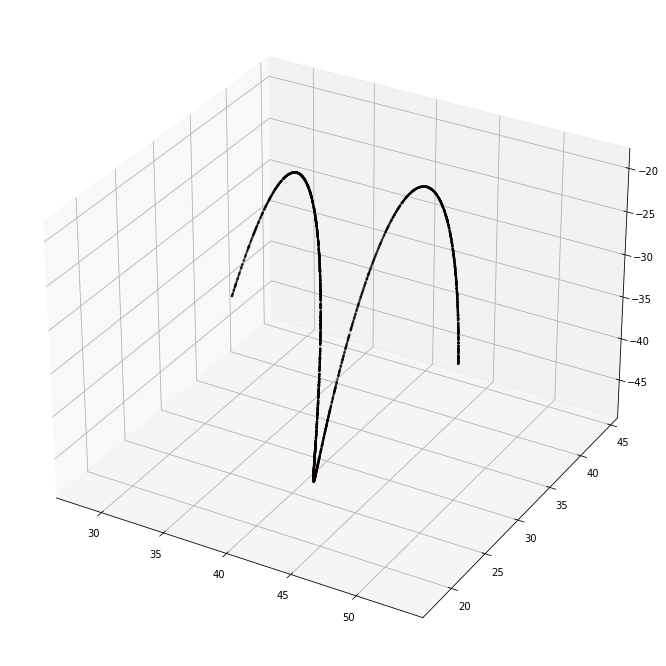

2


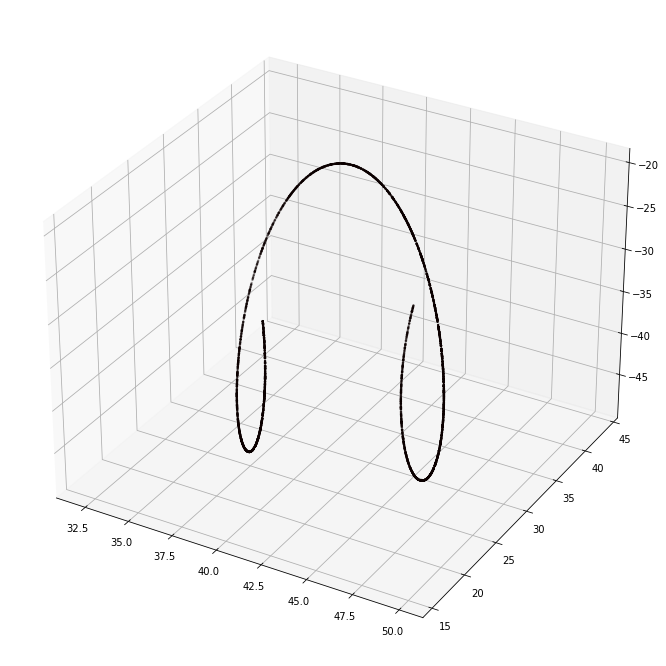

3


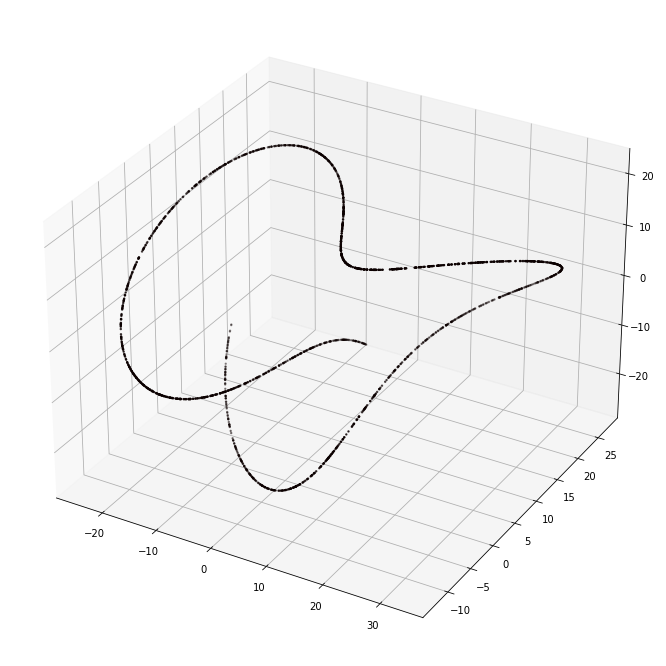

4


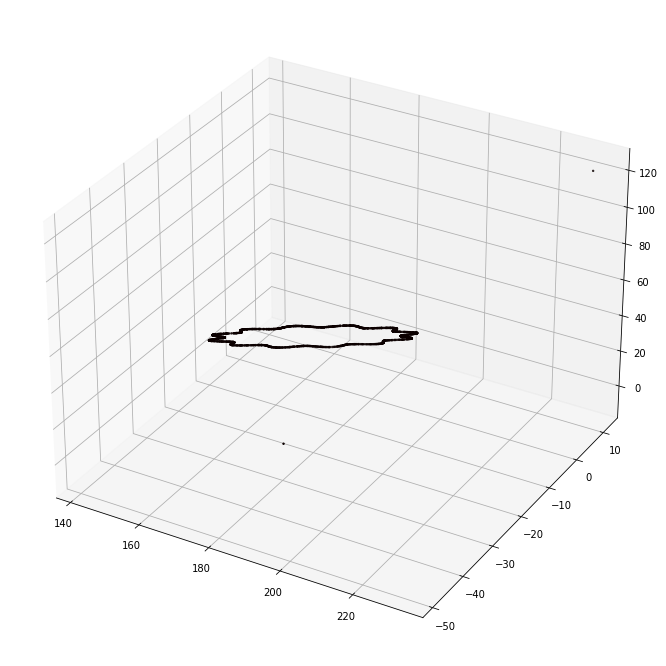

6


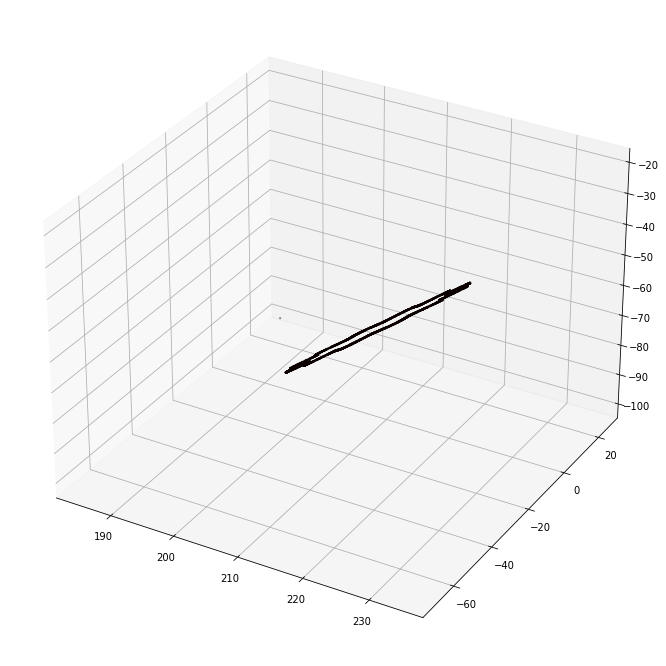

9


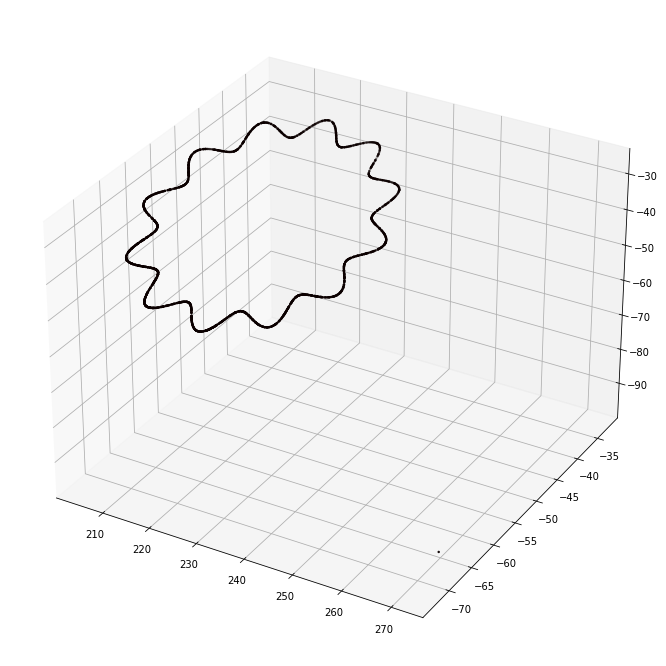

14


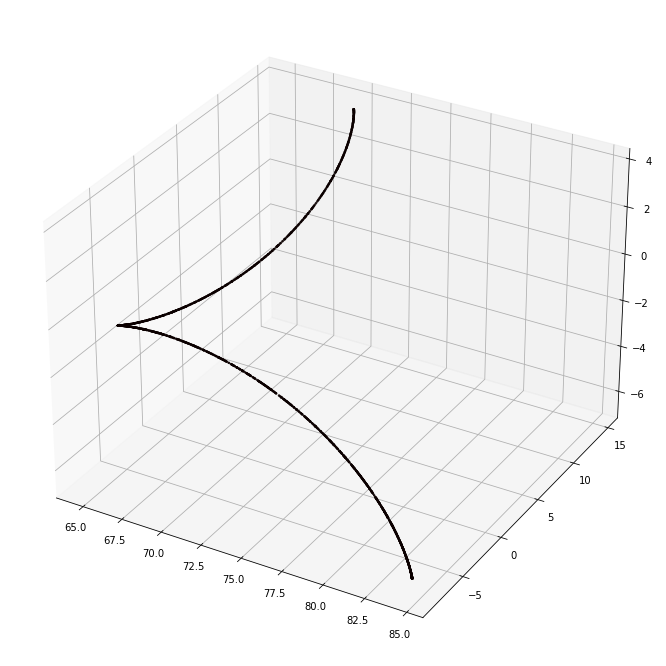

15


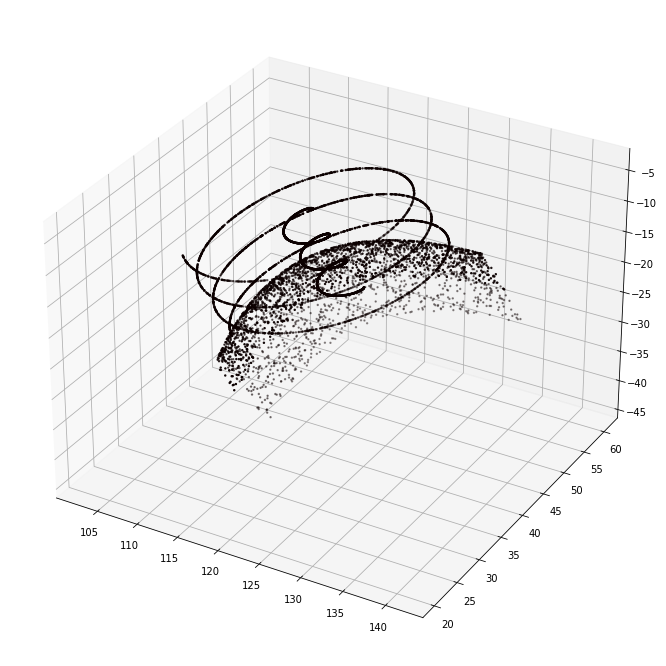

19


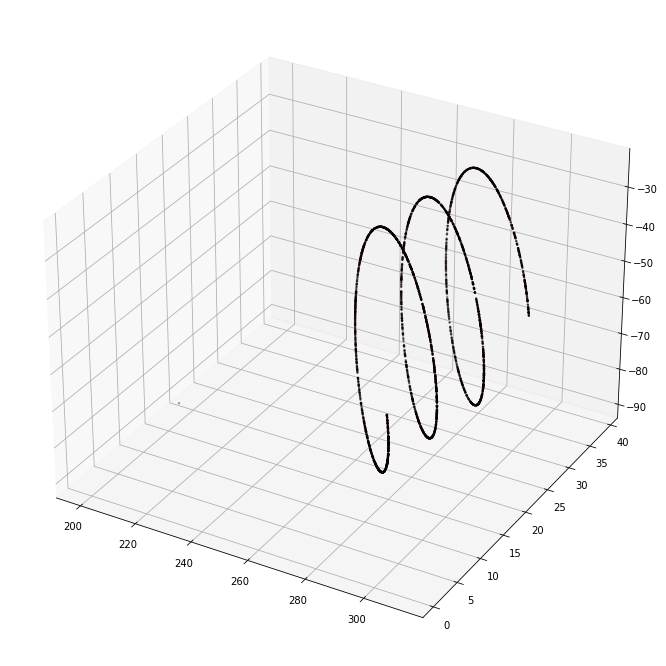

20


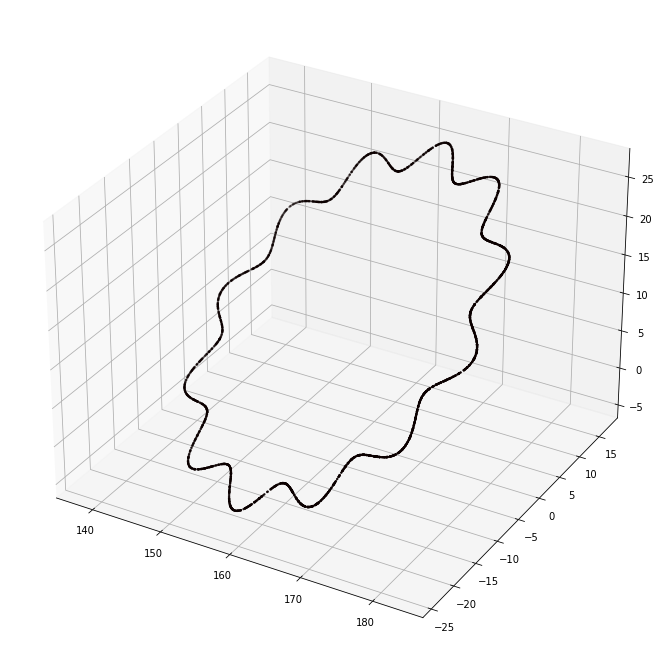

25


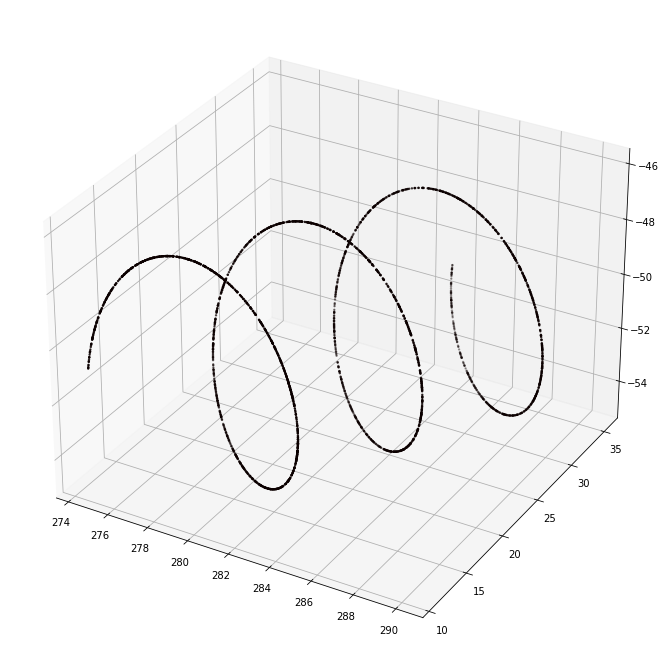

26


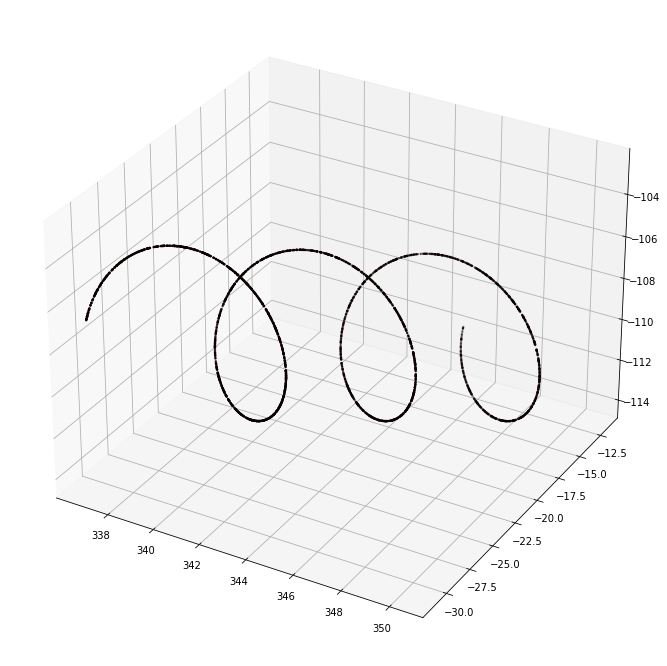

27


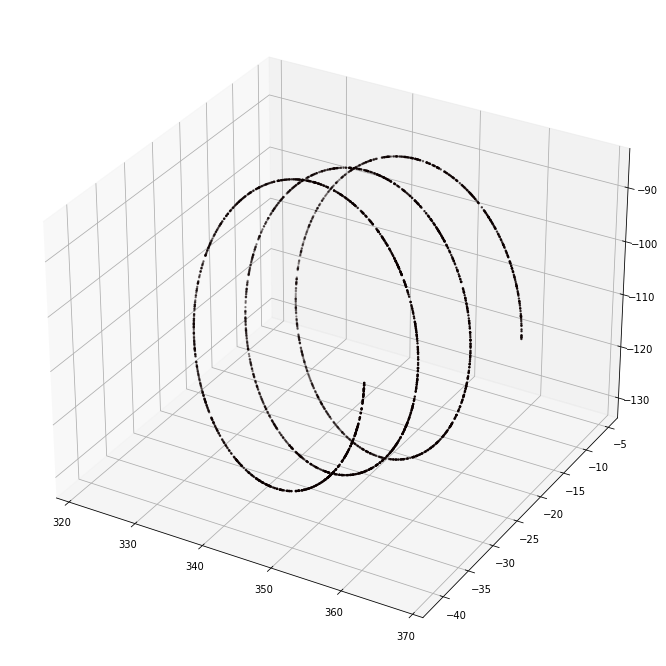

28


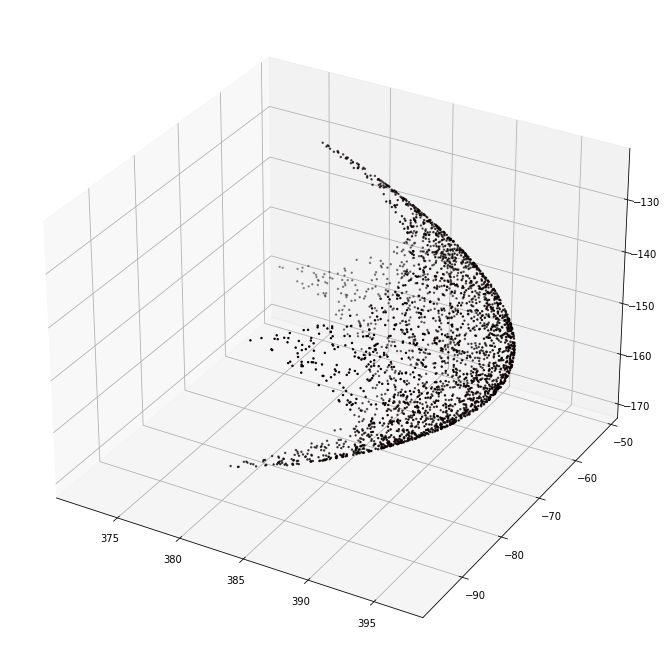

9986


count    44324.000000
mean        14.204472
std          9.178781
min          0.000000
25%          4.000000
50%         15.000000
75%         20.000000
max         28.000000
Name: manifold, dtype: float64

In [201]:
from sklearn.manifold import LocallyLinearEmbedding
%matplotlib inline
cnt = 0
for i in range(10000):
  if len(res[res['manifold'] == i]) < 1000:
    cnt += 1
    continue
  print(i)
  td = 3
  '''tmp = pd.DataFrame(LocallyLinearEmbedding(
    n_components=td,
    n_neighbors=10
  ).fit_transform(
    res[res['manifold'] == i][[j for j in range(d)]]
  ), columns=[i for i in range(td)])
  visualize_4d(tmp)'''
  visualize_4d(res[res['manifold'] == i])
print(cnt)
res['manifold'].describe()

In [202]:
from scipy.sparse import csc_matrix
from sklearn.cluster import SpectralClustering
%matplotlib notebook
tmp = res[res['manifold'] == 15][[i for i in range(d)]]
self = DSCAN(n_neighbor=200, n_ignore=180, n_local=10, max_dis=7).fit(tmp)
tmp['sub'] = self.predict()
visualize_4d(tmp[[0,1,2,'sub']], hot=False)
tmp['sub'].describe()

1000 - 3973
2000 - 5481
3000 - 4898
4000 - 4033
5000 - 3070
6000 - 2091
7000 - 1202
8000 - 209


<IPython.core.display.Javascript object>

count    8222.000000
mean        0.012771
std         0.351143
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        14.000000
Name: sub, dtype: float64

In [207]:
from scipy.sparse import csc_matrix
from sklearn.cluster import SpectralClustering
%matplotlib notebook
tmp = res[res['manifold'] == 15][[i for i in range(d)]]
self = DSCAN(n_neighbor=200, n_ignore=100, n_local=50, max_dis=7).fit(tmp)
n = len(tmp)
row = []
col = []
data = []
print('start')
print(n)
for i in range(n):
  if i % 200 == 0:
    print(i)
  cnt = 0
  for j in self.real_neigh[i]:
    if cnt > 15:
      break
    if self.is_connected(i, j):
      cnt += 1
      row.append(i)
      col.append(j)
      data.append(1)
      row.append(j)
      col.append(i)
      data.append(1)
mat = csc_matrix((np.array(data), (np.array(row), np.array(col))), shape=(n, n))
print('ok')
tmp['manifold'] = SpectralClustering(n_clusters=4, affinity='precomputed_nearest_neighbors').fit_predict(mat)
visualize_4d(tmp[[0,1,2,'manifold']], hot=False)

start
8222
0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
7600
7800
8000
8200
ok


/home/aawaat/.local/lib/python3.10/site-packages/sklearn/neighbors/_base.py:206: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


<IPython.core.display.Javascript object>